# Extend the Hello World example to an $n$-qubit GHZ State

## Step 1: Map the problem to circuits and operators

In [21]:
from qiskit import QuantumCircuit

def get_n_qubit_GHZ_state(n):
    """make GHZ state to n qubits system
    Args:
        n (int): # of q-bit 
    """
    
    qc = QuantumCircuit(n)
    qc.h(0)
    for i in range(n-1): 
        qc.cx(i, i+1)
    return qc

In [22]:
n = 10
qc_draw = get_n_qubit_GHZ_state(n)
qc_draw.draw()

┌───┐                                             
q_0: ┤ H ├──■──────────────────────────────────────────
     └───┘┌─┴─┐                                        
q_1: ─────┤ X ├──■─────────────────────────────────────
          └───┘┌─┴─┐                                   
q_2: ──────────┤ X ├──■────────────────────────────────
               └───┘┌─┴─┐                              
q_3: ───────────────┤ X ├──■───────────────────────────
                    └───┘┌─┴─┐                         
q_4: ────────────────────┤ X ├──■──────────────────────
                         └───┘┌─┴─┐                    
q_5: ─────────────────────────┤ X ├──■─────────────────
                              └───┘┌─┴─┐               
q_6: ──────────────────────────────┤ X ├──■────────────
                                   └───┘┌─┴─┐          
q_7: ───────────────────────────────────┤ X ├──■───────
                                        └───┘┌─┴─┐     
q_8: ────────────────────────────────────────┤ X ├──■──
                                             └───┘┌─┴─┐
q_9: ─────────────────────────────────────────────┤ X ├
                                                  └───┘

In [23]:
n = 100
qc = get_n_qubit_GHZ_state(n)
# qc.draw()

In [24]:
from qiskit.quantum_info import SparsePauliOp

operator_strings = ['Z' + 'I' * i + 'Z' + 'I' * (n-2-i) for i in range(n-1)]
print(operator_strings)
print(len(operator_strings)) 

operators = [SparsePauliOp(operator_string) for operator_string in operator_strings]


['ZZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII', 'ZIIIIIIIIIZIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIIII

## Step 2: Optimize observables

In [28]:
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

backend_name = "ibm_brisbane"
service  = QiskitRuntimeService(channel='ibm_quantum')
backend = service.get_backend(backend_name)
pass_manager = generate_preset_pass_manager(optimization_level=1, backend=backend)

qc_transpiled = pass_manager.run(qc)
operators_transpiled_list = [op.apply_layout(qc_transpiled.layout) for op in operators]

/var/folders/_1/vyxw8wlj1wn0fhb6pl64k4lm0000gn/T/ipykernel_74638/236270623.py:6: DeprecationWarning: The get_backend() method is deprecated as of qiskit-ibm-runtime 0.24 and will be removed no sooner than 3 months after the release date. Please use backend() instead.
  backend = service.get_backend(backend_name)


## Step 3: Execute on the backend

In [29]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import EstimatorOptions

options = EstimatorOptions()
options.resilience_level = 1 # measurement without mitigation
options.optimization_level = 0 # already done in Step 2
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

estimator = Estimator(backend, options=options)

job = estimator.run([(qc_transpiled, operators_transpiled_list)])
job_id = job.job_id()
print(job_id)

ctb1yjac2sk0008c3m50


In [27]:
print(service.instances())

['events/qgss/24-10', 'ibm-q/open/main']


## Step 4: Post-process (and plotting)

In [30]:
job_id = 'ctb1tds0jacg008w6600'
job = service.job(job_id)

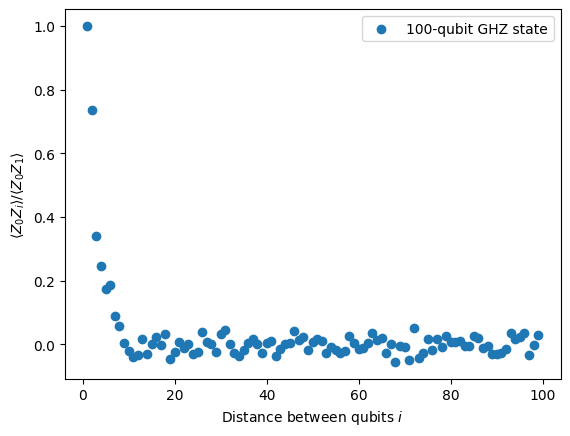

In [35]:
import matplotlib.pyplot as plt

data = list(range(1, len(operators)+1))
result = job.result()[0]
values = result.data.evs #expectation values
values = [v / values[0] for v in values]

plt.scatter(data, values, marker='o', label='100-qubit GHZ state')
plt.xlabel('Distance between qubits $i$')
plt.ylabel(r'$\langle Z_0 Z_i \rangle / \langle Z_0 Z_1 \rangle$')
plt.legend()
plt.show()